# Topic Modelling - CountVectorizer vs TF-IDF - LDA vs NNMF vs LSA

Dans ce Notebook je recherche les méthodes optimales pour identifier des sujets sous-jacents à un corpus de textes (Topics). L'identification des topics se fait en 2 temps:
  1. Création d'un espace vectoriel, dans lequel représenter chaque text (CountVectorizer ou TF-IDF)
  2. Réduction des dimensions (LDA, NNMF ou LSA)

Ici j'essaye toutes les combinaisons de méthodes, pour identifier quelles méthodes sont optimales. Je mesure les performances de chaque modèle, en comptant le temps de calcul et en mesurant le score de cohérence des topics.

In [ ]:
# Connect Google Colab to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/QueryResults_Clean2.zip

Archive:  /content/gdrive/MyDrive/QueryResults_Clean2.zip
  inflating: QueryResults_Clean2.csv  


J'importe des questions de Stack Overflow, qui ont déjà été pré-traitées pour un projet précédent.

In [ ]:
# Import Data

import pandas as pd

Data = pd.read_csv('/content/QueryResults_Clean2.csv', sep=',', engine='python', error_bad_lines=False)

## 1. Représentation des textes dans un espace multi-dimensionnel: CountVectorizer et TF-IDF

Ici je représente chacun des 50.000 textes dans un espace-vectoriel, où chaque dimension est un mot. J'applique d'abord le CountVectorizer, puis le TF-IDF.

Le CountVectorizer (ci-dessous) compte simplement le nombre de fois que chaque mot est utilisé dans chaque texte.

In [ ]:
# Count vectorizer

from sklearn.feature_extraction.text import CountVectorizer

Corpus = []

for i in range(len(Data)):
  Corpus.append(str(Data['Clean_Bags'].iloc[i]))

count_vectorizer = CountVectorizer(analyzer='word',stop_words= 'english')

X = count_vectorizer.fit_transform(Corpus)

  # Store Count vectorizer in a DataFrame

Count_Data = pd.DataFrame(data = X.toarray(),columns = count_vectorizer.get_feature_names())

Le TF-IDF compte la fréquence du mot dans chaque texte (nombre de fois qu'il est utilisé dans un texte, divisé par le nombre de mots dans le même texte), divisé ensuite par le logarithme de la fréquence inversée de ce terme dans le corpus de textes. 

L'intérêt de cette méthode - comparée au CountVectorizer - est que chaque mot est pondéré selon sa rareté. En effet, ceteris-paribus, un terme rare dans le corpus de textes aura un poids plus important, et un terme fréquent dans le corpus de textes aura un poids plus faible. 

Cette méthode a donc l'avantage d'accorder plus de poids aux mots qui ont une forte singularité, qu'aux mots courrants de la langue anglaise.  

In [ ]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer

Corpus = []

for i in range(len(Data)):
  Corpus.append(str(Data['Clean_Bags'].iloc[i]))

TFIDF = TfidfVectorizer(analyzer='word',stop_words= 'english')

X = TFIDF.fit_transform(Corpus)

  # Store Count vectorizer in a DataFrame

TFIDF_Data = pd.DataFrame(data = X.toarray(),columns = TFIDF.get_feature_names())

## 2. Réduction des dimensions: LDA, NNMF et LSA

Ci-dessous je définis une fonction qui calcule le score de cohérence pour chaque topic. Dans un second temps - puisqu'il y a plusieurs topics - je calcule le score de cohérence moyen des topics, et le coeficient de variation de la cohérence des topics. 


Le score de cohérence calcule la similarité entre les 10 mots les plus significatifs de chaque Topic. La similarité entre 2 mots repose sur la méthode de UMass (logarithme du ratio entre le nombre de textes contenant deux mots - ex: "python" et "Jupiter" - divisé par le nombre de textes ne contenant qu'un seul des deux mots - ex: "python"). Si 2 mots sont toujours utilisés ensemble dans les textes, alors ils seront considérés comme ayant une similarité maximale. Si en revanche ils apparaissent rarement dans les même texte, leur similarité sera considéré comme minimale. 

La cohérence d'un topic est comprise entre ]-infini;0]. 

In [ ]:
# Define function to calculate Coherence score

import math
import statistics

def Topic_Coherence(DataFrame, Components, Features):

  Topic_Words = []

  for j,topic in enumerate(Components):
    Words = [Features[j] for j in topic.argsort()[-10:]]
    Topic_Words.append(Words)

  Topic_Coherence = []

  for i in range(len(Topic_Words)):
    Coherence = 0
    for k in range(10):
      for h in range(10):
        if k != h :
          bla = (len(DataFrame[(DataFrame[Topic_Words[i][k]] > 0) & (DataFrame[Topic_Words[i][h]] > 0)]) + 1) / len(DataFrame[DataFrame[Topic_Words[i][k]] > 0])
          UMass = math.log(bla)
          Coherence = Coherence + UMass
    Topic_Coherence.append(Coherence)

  Average_Coherence = sum(Topic_Coherence) / len(Topic_Words)
  CoeficientVariation_Coherence = statistics.pstdev(Topic_Coherence) / abs(Average_Coherence)
  
  return Average_Coherence, CoeficientVariation_Coherence

### 2.1. LDA

Contrairement aux 2 autres méthodes (LSA, NNMF) le Latent dirichlet allocation (LDA) ne reopose pas sur une simple réduction des dimensions, en décomposant la matrice d'origine comme étant le produit de plusieurs matrices de dimensions inférieures.

En effet, la méthode du LDA repose sur l'hypothèse que les topics sous-jacents suivent une loi de dirichlet (dont le LDA identifie les paramêtres), et que les mots au sein des topics suivent eux-même une autre loi de dirichlet (dont le LDA identifie aussi les paramêtres). 

Ainsi, contrairement aux méthodes de LSA et de NNMF, la méthode de LDA est une méthode paramétrique, qui repose sur l'hypothèse que les topics et les mots des topics suivent une loi de probabilité qu'il s'agit d'identifier. 

C'est une méthode qui est plus complexe en terme de calculs, et qui nécessite plus de temps que le LSA ou le NNMF.

#### 2.1.1. LDA sur CountVectorizer

nb_topics :  5  - time :  0:02:04.329485
nb_topics :  10  - time :  0:04:10.490857
nb_topics :  15  - time :  0:06:16.696529
nb_topics :  20  - time :  0:08:24.408483
nb_topics :  25  - time :  0:10:34.144217
nb_topics :  30  - time :  0:12:44.479514
nb_topics :  35  - time :  0:14:59.082779
nb_topics :  40  - time :  0:17:17.043381
nb_topics :  45  - time :  0:19:39.469325
nb_topics :  50  - time :  0:22:06.873007
nb_topics :  55  - time :  0:24:40.286167
nb_topics :  60  - time :  0:27:19.135725
nb_topics :  65  - time :  0:30:03.050285
nb_topics :  70  - time :  0:32:52.446261
nb_topics :  75  - time :  0:35:50.367727
nb_topics :  80  - time :  0:38:53.150604
nb_topics :  85  - time :  0:42:01.549114
nb_topics :  90  - time :  0:45:15.818654
nb_topics :  95  - time :  0:48:37.516937
nb_topics :  100  - time :  0:52:03.094212


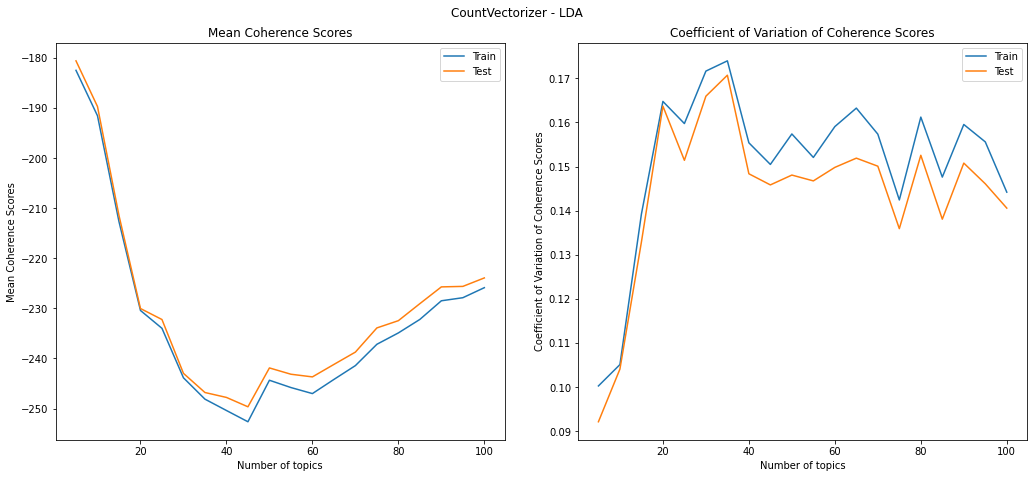

In [ ]:
# Apply Latent Dirichlet Allocation (LDA) to CountVectorizer

import time
import datetime

start = time.time()

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = Count_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_Count_LDA_Coherence_train = []
Mean_Count_LDA_Coherence_test = []
CV_Count_LDA_Coherence_train = []
CV_Count_LDA_Coherence_test = []
Topics = []

for i in range(5, 101, 5):

  lda = LatentDirichletAllocation(n_components=i,
                                random_state=100)
  lda.fit(X_train)

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, lda.components_, count_vectorizer.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, lda.components_, count_vectorizer.get_feature_names())

  Mean_Count_LDA_Coherence_train.append(AvCoherence_tr)
  Mean_Count_LDA_Coherence_test.append(AvCoherence_tst)
  CV_Count_LDA_Coherence_train.append(CVCoherence_tr)
  CV_Count_LDA_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('CountVectorizer - LDA')
axs[0].plot(Topics,  Mean_Count_LDA_Coherence_train)
axs[0].plot(Topics,  Mean_Count_LDA_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_Count_LDA_Coherence_train)
axs[1].plot(Topics, CV_Count_LDA_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

#### 2.1.2. LDA sur TF-IDF

nb_topics :  5  - time :  0:01:11.870469
nb_topics :  10  - time :  0:02:19.100801
nb_topics :  15  - time :  0:03:27.906696
nb_topics :  20  - time :  0:04:37.362173
nb_topics :  25  - time :  0:05:49.990749
nb_topics :  30  - time :  0:07:05.767179
nb_topics :  35  - time :  0:08:24.656972
nb_topics :  40  - time :  0:09:47.879490
nb_topics :  45  - time :  0:11:13.951826
nb_topics :  50  - time :  0:12:46.882098
nb_topics :  55  - time :  0:14:23.221429
nb_topics :  60  - time :  0:16:05.836683
nb_topics :  65  - time :  0:17:52.924744
nb_topics :  70  - time :  0:19:44.606377
nb_topics :  75  - time :  0:21:42.902364
nb_topics :  80  - time :  0:23:44.687961
nb_topics :  85  - time :  0:25:52.711146
nb_topics :  90  - time :  0:28:06.956173
nb_topics :  95  - time :  0:30:25.229635
nb_topics :  100  - time :  0:32:49.378382


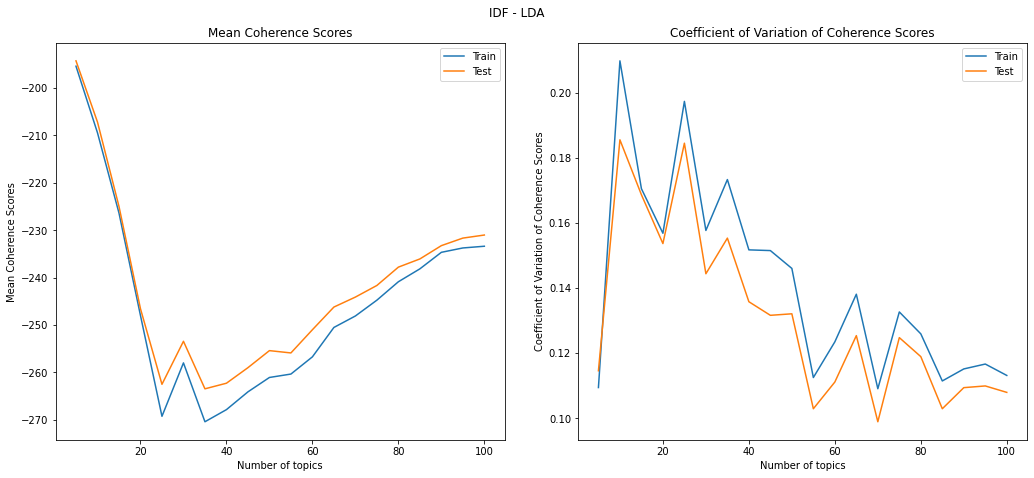

In [ ]:
# Apply Latent Dirichlet Allocation (LDA) to TF-IDF

import time
import datetime

start = time.time()

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = TFIDF_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_TFIDF_LDA_Coherence_train = []
Mean_TFIDF_LDA_Coherence_test = []
CV_TFIDF_LDA_Coherence_train = []
CV_TFIDF_LDA_Coherence_test = []
Topics = []

for i in range(5, 101, 5):

  lda = LatentDirichletAllocation(n_components=i,
                                random_state=100)
  lda.fit(X_train)

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, lda.components_, TFIDF.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, lda.components_, TFIDF.get_feature_names())

  Mean_TFIDF_LDA_Coherence_train.append(AvCoherence_tr)
  Mean_TFIDF_LDA_Coherence_test.append(AvCoherence_tst)
  CV_TFIDF_LDA_Coherence_train.append(CVCoherence_tr)
  CV_TFIDF_LDA_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('IDF - LDA')
axs[0].plot(Topics,  Mean_TFIDF_LDA_Coherence_train)
axs[0].plot(Topics,  Mean_TFIDF_LDA_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_TFIDF_LDA_Coherence_train)
axs[1].plot(Topics, CV_TFIDF_LDA_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

### 2.2. LSA

On travail ici avec une matrice "X" à 50.000 lignes (nb de textes) et à 500 colonnes (nb de mots).

La méthode de LSA (Latent Semantic Analysis) utilise une décomposition SVD, qui consiste à identifier les valeurs propres de la matrice 50.000 x 500, ainsi que les vecteurs propres correspondants. Il s'ensuit que l'on obtient une matrice diagonale "D" avec "K" valeurs propres, une matrice "V" avec "K" vecteurs propres de dimension "K" x 500, ainsi qu'une matrice U de dimension 50.000 x "K". Cette matrice U est la matrice qui correpond à la matrice que l'on cherche à obtenir (avec les 50.000 textes et "K" topics identifiés).

La matrice d'origine X se décompose comme suit:
X = UD(V)^T

#### 2.2.1. LSA sur CountVectorizer

nb_topics :  5  - time :  0:00:09.920328
nb_topics :  10  - time :  0:00:25.899935
nb_topics :  15  - time :  0:00:47.566184
nb_topics :  20  - time :  0:01:15.421816
nb_topics :  25  - time :  0:01:49.920862
nb_topics :  30  - time :  0:02:29.581631
nb_topics :  35  - time :  0:03:14.128493
nb_topics :  40  - time :  0:04:05.948282
nb_topics :  45  - time :  0:05:01.827767
nb_topics :  50  - time :  0:06:01.752952
nb_topics :  55  - time :  0:07:07.789300
nb_topics :  60  - time :  0:08:19.432189
nb_topics :  65  - time :  0:09:35.340888
nb_topics :  70  - time :  0:10:54.766697
nb_topics :  75  - time :  0:12:18.798927
nb_topics :  80  - time :  0:13:47.085192
nb_topics :  85  - time :  0:15:21.494866
nb_topics :  90  - time :  0:16:58.767214
nb_topics :  95  - time :  0:18:40.994486
nb_topics :  100  - time :  0:20:24.507276


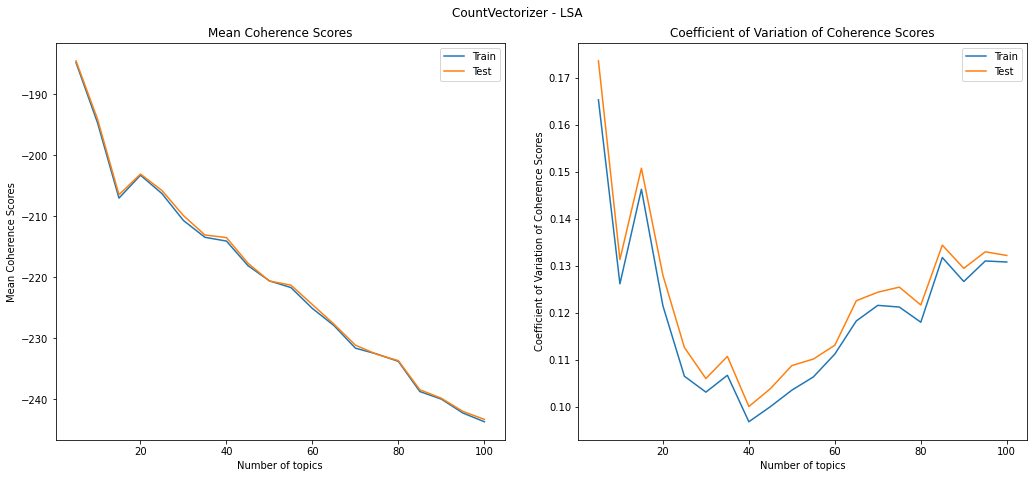

In [ ]:
# Apply Latent Semantic Analysis (LSA) to CountVectorizer

import time
import datetime

start = time.time()

from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = Count_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_Count_LSA_Coherence_train = []
Mean_Count_LSA_Coherence_test = []
CV_Count_LSA_Coherence_train = []
CV_Count_LSA_Coherence_test = []
Topics = []

for i in range(5, 101, 5):

  lsa = TruncatedSVD(n_components=i, n_iter=7, random_state=42)

  lsa.fit(X_train)

  # Apply Latent Semantic Analysis (LSA) to identify underlying topics.

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, lsa.components_, count_vectorizer.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, lsa.components_, count_vectorizer.get_feature_names())

  Mean_Count_LSA_Coherence_train.append(AvCoherence_tr)
  Mean_Count_LSA_Coherence_test.append(AvCoherence_tst)
  CV_Count_LSA_Coherence_train.append(CVCoherence_tr)
  CV_Count_LSA_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))



import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('CountVectorizer - LSA')
axs[0].plot(Topics,  Mean_Count_LSA_Coherence_train)
axs[0].plot(Topics,  Mean_Count_LSA_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_Count_LSA_Coherence_train)
axs[1].plot(Topics, CV_Count_LSA_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

#### 2.2.2. LSA sur TF-IDF

nb_topics :  5  - time :  0:00:07.925891
nb_topics :  10  - time :  0:00:21.514341
nb_topics :  15  - time :  0:00:40.875825
nb_topics :  20  - time :  0:01:06.462837
nb_topics :  25  - time :  0:01:38.176941
nb_topics :  30  - time :  0:02:15.265308
nb_topics :  35  - time :  0:02:57.912899
nb_topics :  40  - time :  0:03:45.514121
nb_topics :  45  - time :  0:04:37.184371
nb_topics :  50  - time :  0:05:35.618006
nb_topics :  55  - time :  0:06:38.919637
nb_topics :  60  - time :  0:07:46.903220
nb_topics :  65  - time :  0:08:54.867145
nb_topics :  70  - time :  0:10:09.235144
nb_topics :  75  - time :  0:11:26.967466
nb_topics :  80  - time :  0:12:50.743175
nb_topics :  85  - time :  0:14:19.527823
nb_topics :  90  - time :  0:15:53.778273
nb_topics :  95  - time :  0:17:31.535257
nb_topics :  100  - time :  0:19:12.231486


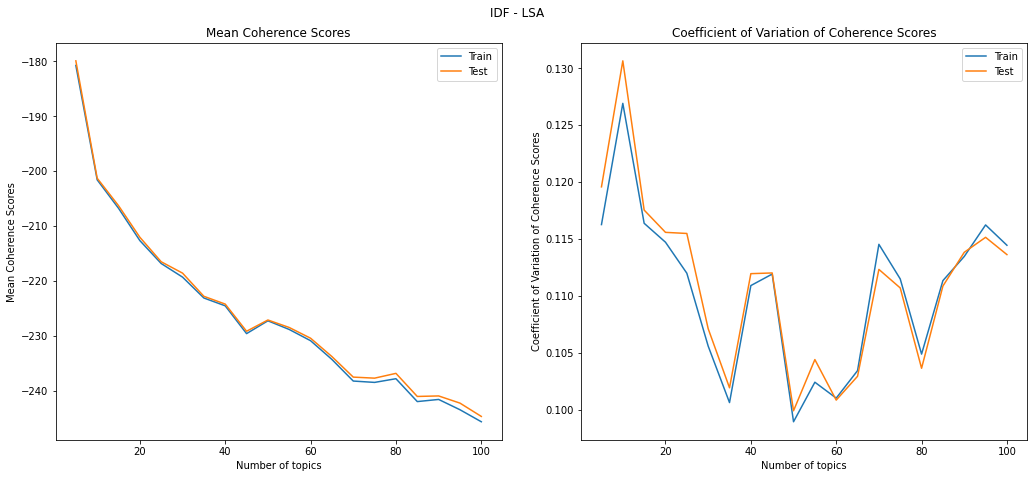

In [ ]:
# Apply Latent Semantic Analysis (LSA) to TF-IDF

import time
import datetime

start = time.time()

from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = TFIDF_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_TFIDF_LSA_Coherence_train = []
Mean_TFIDF_LSA_Coherence_test = []
CV_TFIDF_LSA_Coherence_train = []
CV_TFIDF_LSA_Coherence_test = []
Topics = []

for i in range(5, 101, 5):

  lsa = TruncatedSVD(n_components=i, n_iter=7, random_state=42)

  lsa.fit(X_train)

  # Apply Latent Semantic Analysis (LSA) to identify underlying topics.

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, lsa.components_, TFIDF.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, lsa.components_, TFIDF.get_feature_names())

  Mean_TFIDF_LSA_Coherence_train.append(AvCoherence_tr)
  Mean_TFIDF_LSA_Coherence_test.append(AvCoherence_tst)
  CV_TFIDF_LSA_Coherence_train.append(CVCoherence_tr)
  CV_TFIDF_LSA_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))



import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('IDF - LSA')
axs[0].plot(Topics,  Mean_TFIDF_LSA_Coherence_train)
axs[0].plot(Topics,  Mean_TFIDF_LSA_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_TFIDF_LSA_Coherence_train)
axs[1].plot(Topics, CV_TFIDF_LSA_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

### 2.3. NNMF

On travail ici avec une matrice à 50.000 lignes (nb de textes) et à 500 colonnes (nb de mots).

La méthode de NNMF cherche à décomposer la matrice 50.000 x 500 comme étant le produit de 2 matrices à dimension inférieures. La première matrice "W" sera de dimension 50.000 x "K", et la seconde matrice "H" sera de dimension "K" x 500.

La matrice "W" (de dimension 50.000 x "K") correspond à la matrice avec dimensions réduites, où les "K" colonnes correspondent aux "K" topics sous-jacents. On trouve "W" et "H" en minimizant le problème suivant:

min ||X - WH||²

où X est la matrice d'origine, "W" la matrice la matrice aux "K" topics, et "H" une matrice Kx500 (qui ne sert pas pour la suite).

#### 2.3.1. NNMF sur CountVectorizer

nb_topics :  5  - time :  0:00:19.451612
nb_topics :  10  - time :  0:00:51.508909
nb_topics :  15  - time :  0:01:46.075038
nb_topics :  20  - time :  0:02:54.503162
nb_topics :  25  - time :  0:04:06.619097
nb_topics :  30  - time :  0:05:15.461524
nb_topics :  35  - time :  0:07:07.395184
nb_topics :  40  - time :  0:08:38.093927
nb_topics :  45  - time :  0:10:59.701480
nb_topics :  50  - time :  0:13:34.355149
nb_topics :  55  - time :  0:15:52.388603
nb_topics :  60  - time :  0:18:58.870985
nb_topics :  65  - time :  0:20:45.059111
nb_topics :  70  - time :  0:22:46.739511
nb_topics :  75  - time :  0:24:54.185109
nb_topics :  80  - time :  0:27:03.313398
nb_topics :  85  - time :  0:29:27.914348
nb_topics :  90  - time :  0:32:34.921838
nb_topics :  95  - time :  0:36:20.922237
nb_topics :  100  - time :  0:39:41.881796


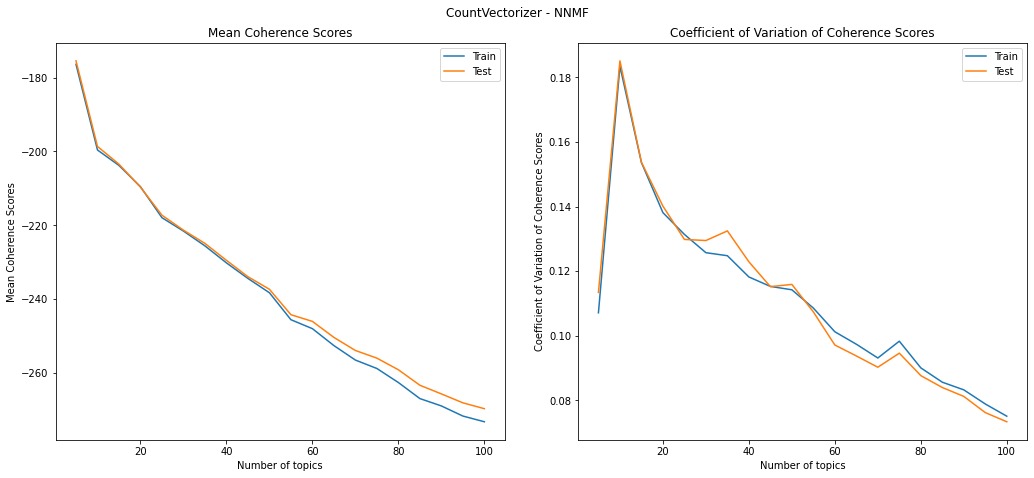

In [ ]:
# Apply Non-Negative Matrix Factorization (NNMF) to CountVectorizer

import time
import datetime

start = time.time()

from sklearn.decomposition import NMF
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = Count_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_Count_NNMF_Coherence_train = []
Mean_Count_NNMF_Coherence_test = []
CV_Count_NNMF_Coherence_train = []
CV_Count_NNMF_Coherence_test = []
Topics = []

for i in range(5, 101, 5):

  nnmf = NMF(n_components=i, init='random', random_state=0)
  nnmf.fit(X)

  # Apply Latent Semantic Analysis (LSA) to identify underlying topics.

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, nnmf.components_, count_vectorizer.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, nnmf.components_, count_vectorizer.get_feature_names())

  Mean_Count_NNMF_Coherence_train.append(AvCoherence_tr)
  Mean_Count_NNMF_Coherence_test.append(AvCoherence_tst)
  CV_Count_NNMF_Coherence_train.append(CVCoherence_tr)
  CV_Count_NNMF_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))



import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('CountVectorizer - NNMF')
axs[0].plot(Topics,  Mean_Count_NNMF_Coherence_train)
axs[0].plot(Topics,  Mean_Count_NNMF_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_Count_NNMF_Coherence_train)
axs[1].plot(Topics, CV_Count_NNMF_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

#### 2.3.2. NNMF sur TF-IDF

nb_topics :  5  - time :  0:00:28.677082
nb_topics :  10  - time :  0:01:10.851315
nb_topics :  15  - time :  0:02:02.956840
nb_topics :  20  - time :  0:02:52.592368
nb_topics :  25  - time :  0:03:56.883286
nb_topics :  30  - time :  0:05:09.020862
nb_topics :  35  - time :  0:06:05.539429
nb_topics :  40  - time :  0:07:35.598517
nb_topics :  45  - time :  0:09:02.370761
nb_topics :  50  - time :  0:11:07.424066
nb_topics :  55  - time :  0:13:29.826836
nb_topics :  60  - time :  0:16:27.042111
nb_topics :  65  - time :  0:19:40.478974
nb_topics :  70  - time :  0:23:15.797276
nb_topics :  75  - time :  0:26:30.492234
nb_topics :  80  - time :  0:30:04.125936
nb_topics :  85  - time :  0:34:40.892239
nb_topics :  90  - time :  0:39:36.490347
nb_topics :  95  - time :  0:44:27.093853
nb_topics :  100  - time :  0:49:34.485523


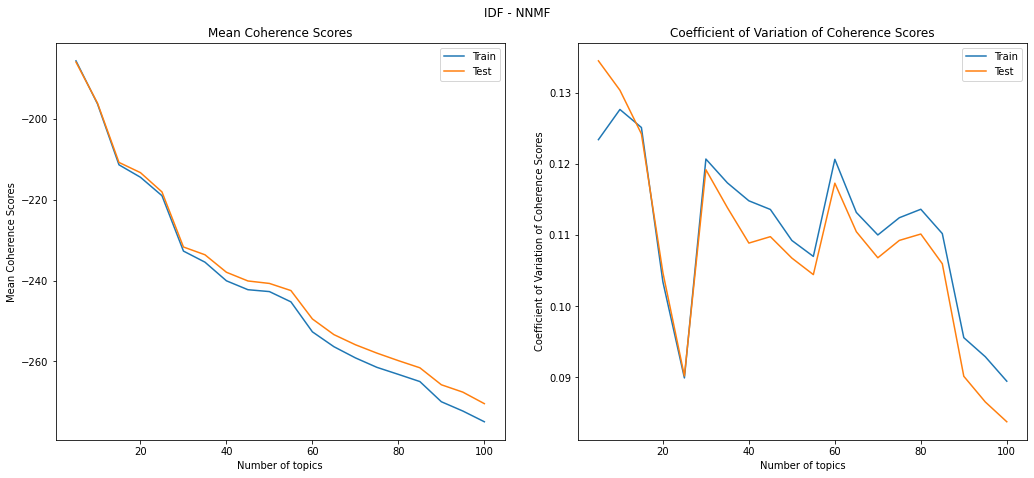

In [ ]:
# Apply Non-Negative Matrix Factorization (NNMF) to TF-IDF

import time
import datetime

start = time.time()

from sklearn.decomposition import NMF
from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split

X = TFIDF_Data

X_train, X_test = train_test_split(X,test_size=0.3,random_state=100)

Mean_TFIDF_NNMF_Coherence_train = []
Mean_TFIDF_NNMF_Coherence_test = []
CV_TFIDF_NNMF_Coherence_train = []
CV_TFIDF_NNMF_Coherence_test = []
Topics = []


for i in range(5, 101, 5):

  nnmf = NMF(n_components=i, init='random', random_state=0)
  nnmf.fit(X)

  # Apply Latent Semantic Analysis (LSA) to identify underlying topics.

  AvCoherence_tr, CVCoherence_tr = Topic_Coherence(X_train, nnmf.components_, TFIDF.get_feature_names())
  AvCoherence_tst, CVCoherence_tst = Topic_Coherence(X_test, nnmf.components_, TFIDF.get_feature_names())

  Mean_TFIDF_NNMF_Coherence_train.append(AvCoherence_tr)
  Mean_TFIDF_NNMF_Coherence_test.append(AvCoherence_tst)
  CV_TFIDF_NNMF_Coherence_train.append(CVCoherence_tr)
  CV_TFIDF_NNMF_Coherence_test.append(CVCoherence_tst)
  Topics.append(i)
  
  end = time.time()

  print('nb_topics : ', i, ' - time : ', str(datetime.timedelta(seconds=end-start)))


import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

fig.set_figheight(7)
fig.set_figwidth(15)

fig.suptitle('IDF - NNMF')
axs[0].plot(Topics,  Mean_TFIDF_NNMF_Coherence_train)
axs[0].plot(Topics,  Mean_TFIDF_NNMF_Coherence_test)
axs[0].legend(['Train', 'Test'])
axs[0].set(title='Mean Coherence Scores', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1].plot(Topics, CV_TFIDF_NNMF_Coherence_train)
axs[1].plot(Topics, CV_TFIDF_NNMF_Coherence_test)
axs[1].legend(['Train', 'Test'])
axs[1].set(title='Coefficient of Variation of Coherence Scores', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

## 3. Evaluation des Performances

## 3.1. Dans l'ensemble

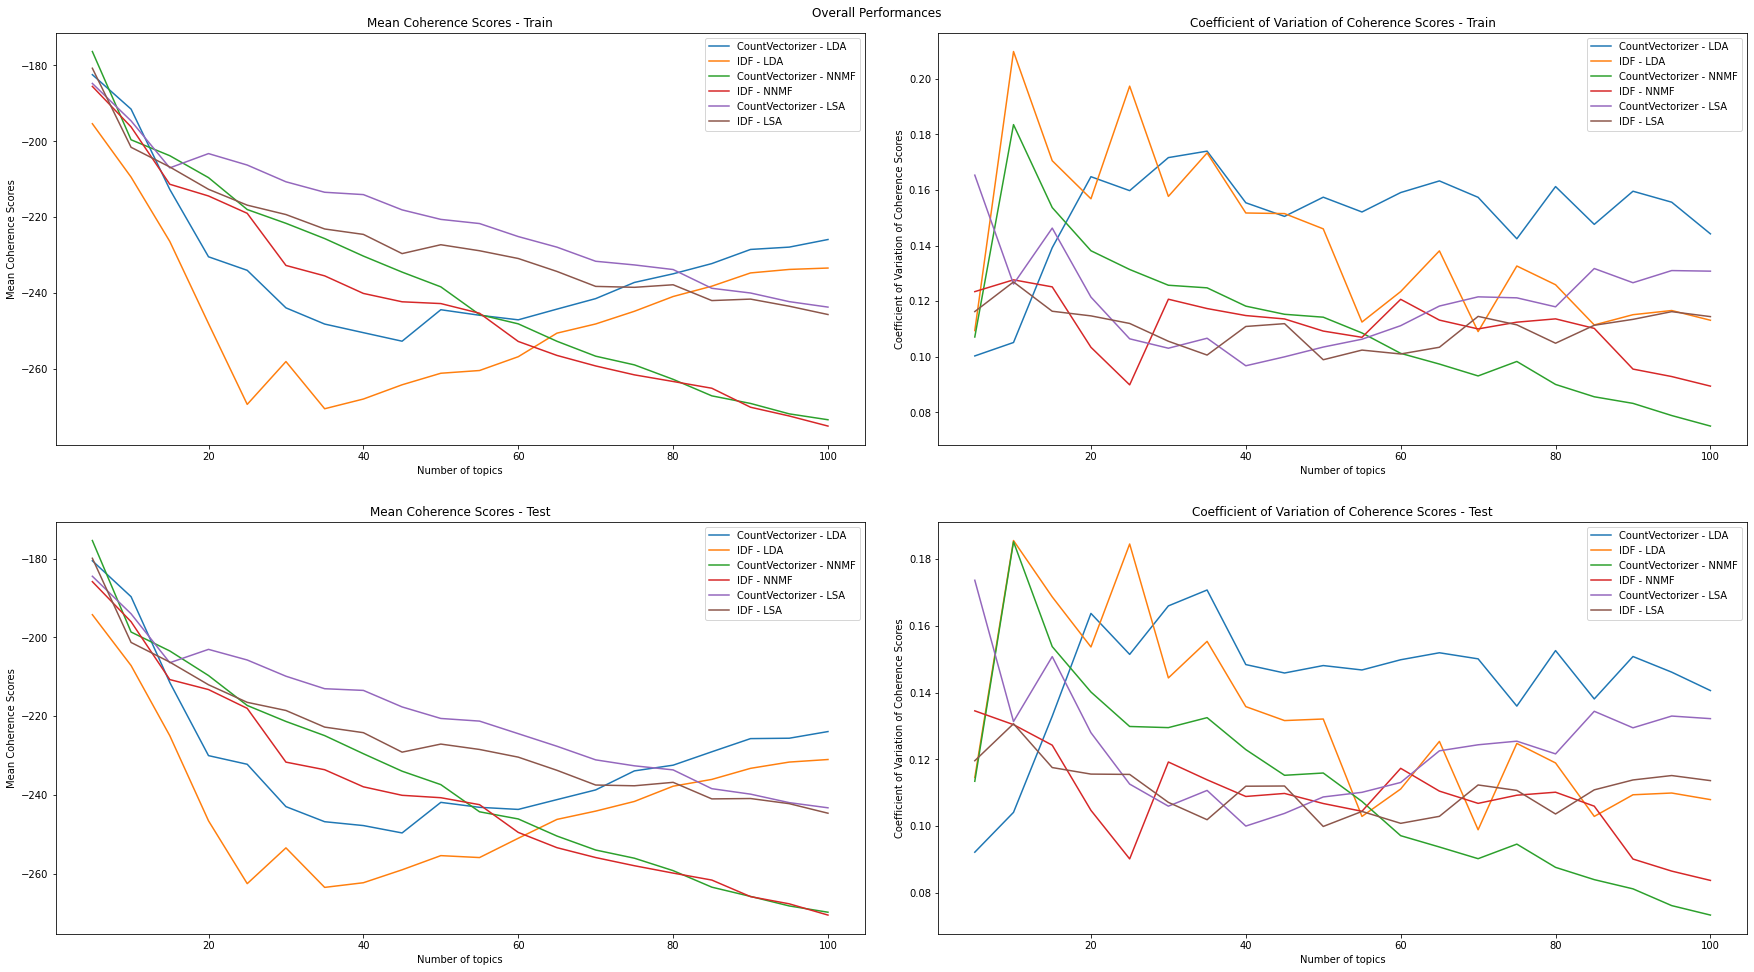

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

fig.set_figheight(14)
fig.set_figwidth(25)

fig.suptitle('Overall Performances')
axs[0,0].plot(Topics, Mean_Count_LDA_Coherence_train)
axs[0,0].plot(Topics, Mean_TFIDF_LDA_Coherence_train)
axs[0,0].plot(Topics, Mean_Count_NNMF_Coherence_train)
axs[0,0].plot(Topics, Mean_TFIDF_NNMF_Coherence_train)
axs[0,0].plot(Topics, Mean_Count_LSA_Coherence_train)
axs[0,0].plot(Topics, Mean_TFIDF_LSA_Coherence_train)
axs[0,0].legend(['CountVectorizer - LDA', 'IDF - LDA', 'CountVectorizer - NNMF', 'IDF - NNMF', 'CountVectorizer - LSA', 'IDF - LSA'])
axs[0,0].set(title='Mean Coherence Scores - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[0,1].plot(Topics, CV_Count_LDA_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_LDA_Coherence_train)
axs[0,1].plot(Topics, CV_Count_NNMF_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_NNMF_Coherence_train)
axs[0,1].plot(Topics, CV_Count_LSA_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_LSA_Coherence_train)
axs[0,1].legend(['CountVectorizer - LDA', 'IDF - LDA', 'CountVectorizer - NNMF', 'IDF - NNMF', 'CountVectorizer - LSA', 'IDF - LSA'])
axs[0,1].set(title='Coefficient of Variation of Coherence Scores - Train', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

axs[1,0].plot(Topics, Mean_Count_LDA_Coherence_test)
axs[1,0].plot(Topics, Mean_TFIDF_LDA_Coherence_test)
axs[1,0].plot(Topics, Mean_Count_NNMF_Coherence_test)
axs[1,0].plot(Topics, Mean_TFIDF_NNMF_Coherence_test)
axs[1,0].plot(Topics, Mean_Count_LSA_Coherence_test)
axs[1,0].plot(Topics, Mean_TFIDF_LSA_Coherence_test)
axs[1,0].legend(['CountVectorizer - LDA', 'IDF - LDA', 'CountVectorizer - NNMF', 'IDF - NNMF', 'CountVectorizer - LSA', 'IDF - LSA'])
axs[1,0].set(title='Mean Coherence Scores - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1,1].plot(Topics, CV_Count_LDA_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_LDA_Coherence_test)
axs[1,1].plot(Topics, CV_Count_NNMF_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_NNMF_Coherence_test)
axs[1,1].plot(Topics, CV_Count_LSA_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_LSA_Coherence_test)
axs[1,1].legend(['CountVectorizer - LDA', 'IDF - LDA', 'CountVectorizer - NNMF', 'IDF - NNMF', 'CountVectorizer - LSA', 'IDF - LSA'])
axs[1,1].set(title='Coefficient of Variation of Coherence Scores - Test', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')


fig.tight_layout(pad=3.0)
fig.show()

- Les résultats sur données Test (2 graphiques du bas) sont comparables aux résultats sur les données Train (2 graphiques du haut).

- La cohérence moyenne est une fonction décroissante du nombre de Topics (surtout pour le LSA et NNMF).

- Le coeficient de variation de la cohérence des topics ne semble pas être fonction du nombre de topics (en tout cas, pas sur toutes les méthodes).

## 3.2. Count-Vectorizer  vs  TF-IDF

### 3.2.1. Cohérence Moyenne des Topics

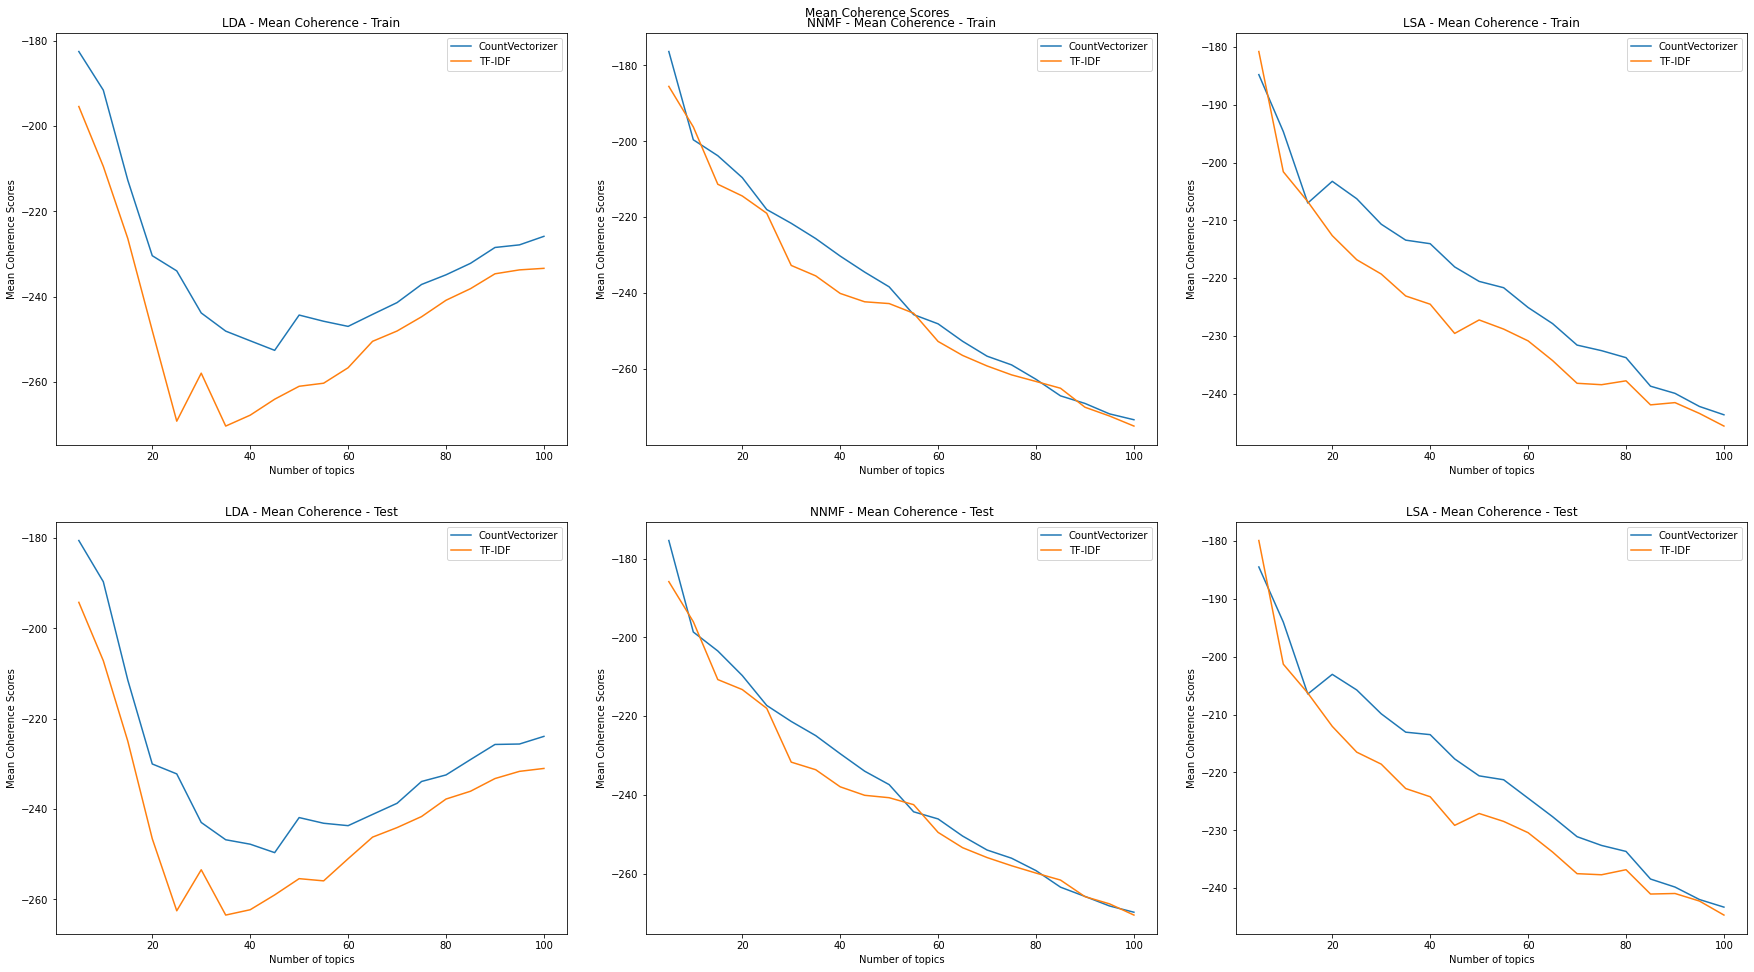

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3)

fig.set_figheight(14)
fig.set_figwidth(25)

fig.suptitle('Mean Coherence Scores')
axs[0,0].plot(Topics, Mean_Count_LDA_Coherence_train)
axs[0,0].plot(Topics, Mean_TFIDF_LDA_Coherence_train)
axs[0,0].legend(['CountVectorizer', 'TF-IDF'])
axs[0,0].set(title='LDA - Mean Coherence - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[0,1].plot(Topics, Mean_Count_NNMF_Coherence_train)
axs[0,1].plot(Topics, Mean_TFIDF_NNMF_Coherence_train)
axs[0,1].legend(['CountVectorizer', 'TF-IDF'])
axs[0,1].set(title='NNMF - Mean Coherence - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[0,2].plot(Topics, Mean_Count_LSA_Coherence_train)
axs[0,2].plot(Topics, Mean_TFIDF_LSA_Coherence_train)
axs[0,2].legend(['CountVectorizer', 'TF-IDF'])
axs[0,2].set(title='LSA - Mean Coherence - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')


axs[1,0].plot(Topics, Mean_Count_LDA_Coherence_test)
axs[1,0].plot(Topics, Mean_TFIDF_LDA_Coherence_test)
axs[1,0].legend(['CountVectorizer', 'TF-IDF'])
axs[1,0].set(title='LDA - Mean Coherence - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1,1].plot(Topics, Mean_Count_NNMF_Coherence_test)
axs[1,1].plot(Topics, Mean_TFIDF_NNMF_Coherence_test)
axs[1,1].legend(['CountVectorizer', 'TF-IDF'])
axs[1,1].set(title='NNMF - Mean Coherence - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1,2].plot(Topics, Mean_Count_LSA_Coherence_test)
axs[1,2].plot(Topics, Mean_TFIDF_LSA_Coherence_test)
axs[1,2].legend(['CountVectorizer', 'TF-IDF'])
axs[1,2].set(title='LSA - Mean Coherence - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

- Le CountVectorizer génère de meilleurs scores de cohérence que la méthode de TF-IDF.

###  3.2.2. Coeficient de Variation des Cohérences des Topics

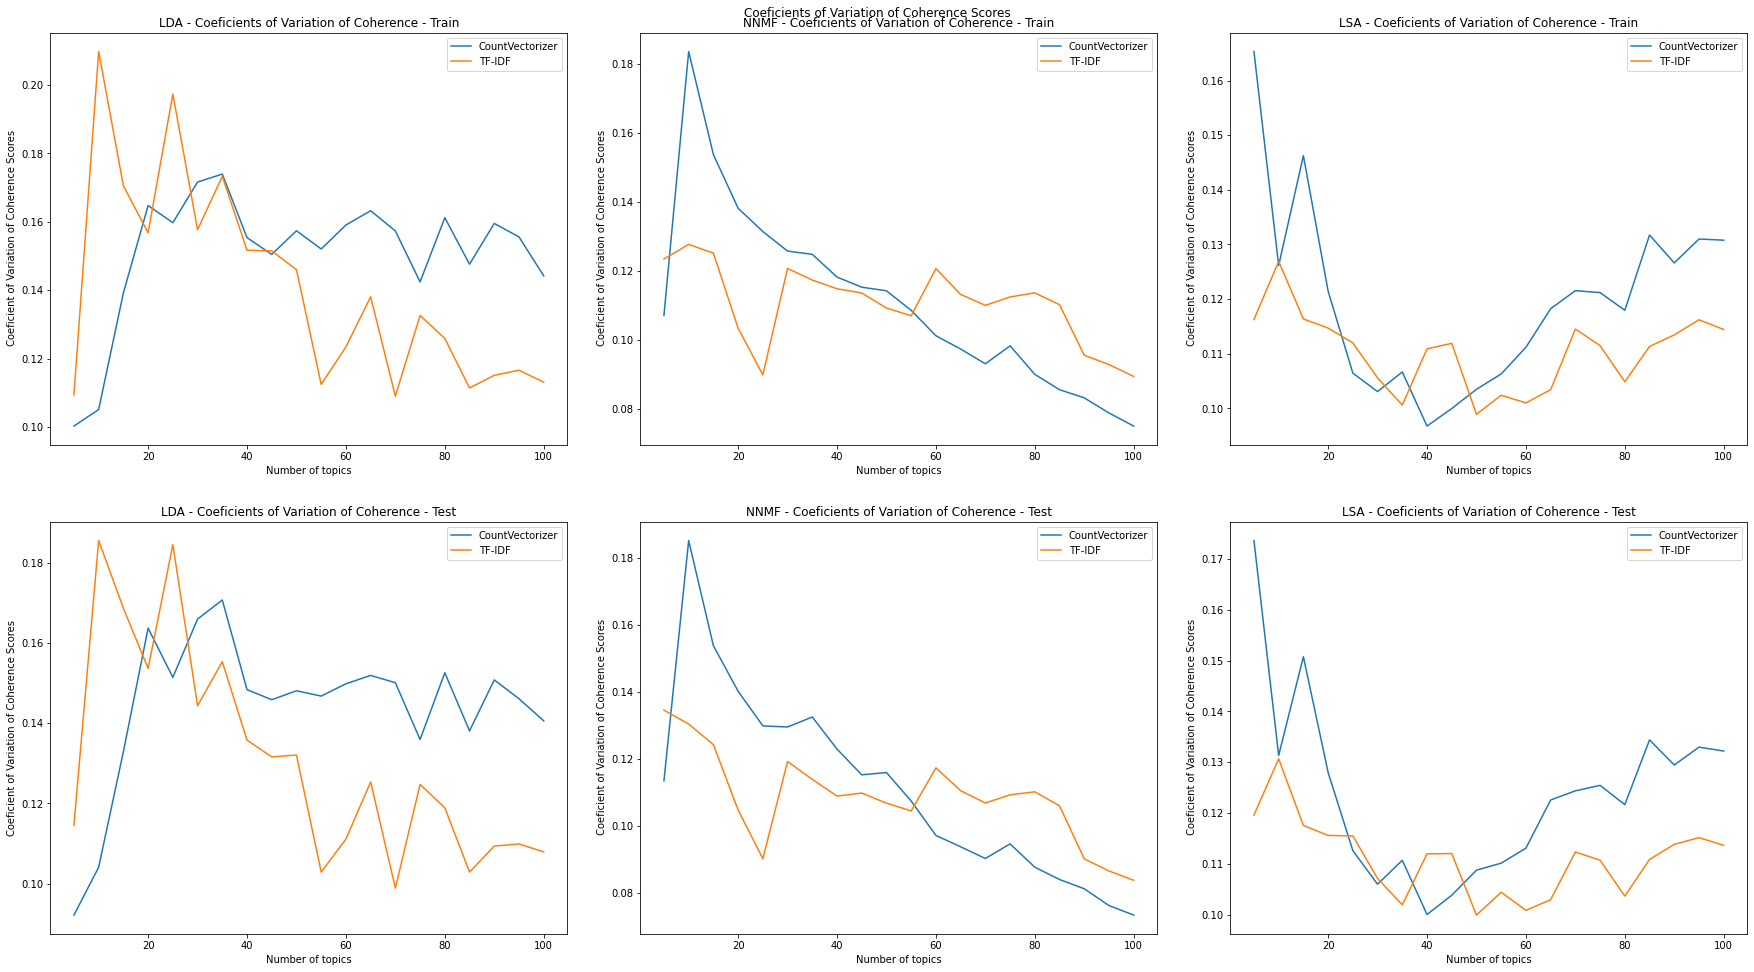

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3)

fig.set_figheight(14)
fig.set_figwidth(25)

fig.suptitle('Coeficients of Variation of Coherence Scores')
axs[0,0].plot(Topics, CV_Count_LDA_Coherence_train)
axs[0,0].plot(Topics, CV_TFIDF_LDA_Coherence_train)
axs[0,0].legend(['CountVectorizer', 'TF-IDF'])
axs[0,0].set(title='LDA - Coeficients of Variation of Coherence - Train', xlabel='Number of topics', ylabel=' Coeficient of Variation of Coherence Scores')

axs[0,1].plot(Topics, CV_Count_NNMF_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_NNMF_Coherence_train)
axs[0,1].legend(['CountVectorizer', 'TF-IDF'])
axs[0,1].set(title='NNMF - Coeficients of Variation of Coherence - Train', xlabel='Number of topics', ylabel=' Coeficient of Variation of Coherence Scores')

axs[0,2].plot(Topics, CV_Count_LSA_Coherence_train)
axs[0,2].plot(Topics, CV_TFIDF_LSA_Coherence_train)
axs[0,2].legend(['CountVectorizer', 'TF-IDF'])
axs[0,2].set(title='LSA - Coeficients of Variation of Coherence - Train', xlabel='Number of topics', ylabel=' Coeficient of Variation of Coherence Scores')


axs[1,0].plot(Topics, CV_Count_LDA_Coherence_test)
axs[1,0].plot(Topics, CV_TFIDF_LDA_Coherence_test)
axs[1,0].legend(['CountVectorizer', 'TF-IDF'])
axs[1,0].set(title='LDA - Coeficients of Variation of Coherence - Test', xlabel='Number of topics', ylabel= 'Coeficient of Variation of Coherence Scores')

axs[1,1].plot(Topics, CV_Count_NNMF_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_NNMF_Coherence_test)
axs[1,1].legend(['CountVectorizer', 'TF-IDF'])
axs[1,1].set(title='NNMF - Coeficients of Variation of Coherence - Test', xlabel='Number of topics', ylabel=' Coeficient of Variation of Coherence Scores')

axs[1,2].plot(Topics, CV_Count_LSA_Coherence_test)
axs[1,2].plot(Topics, CV_TFIDF_LSA_Coherence_test)
axs[1,2].legend(['CountVectorizer', 'TF-IDF'])
axs[1,2].set(title='LSA - Coeficients of Variation of Coherence - Test', xlabel='Number of topics', ylabel=' Coeficient of Variation of Coherence Scores')

fig.tight_layout(pad=3.0)
fig.show()

- Les coéficients de variations de la cohérence des topics est affectée par le choix de la méthode CountVectorizer et TF-IDF, mais pas de manière simple. 

- TF-IDF minimize le coeficient de variation sur le LDA, surtout lorsque les topics sont nombreux.

- CountVectorizer augmente le coeficient de variation avec un faible nombre topics, mais le diminue avec un grand nombre de topics, lorsqu'on utilise le NNMF.

## 3.3. LDA  vs  NNMF vs LSA

###  3.3.1.  Cohérences Moyenne des Topics

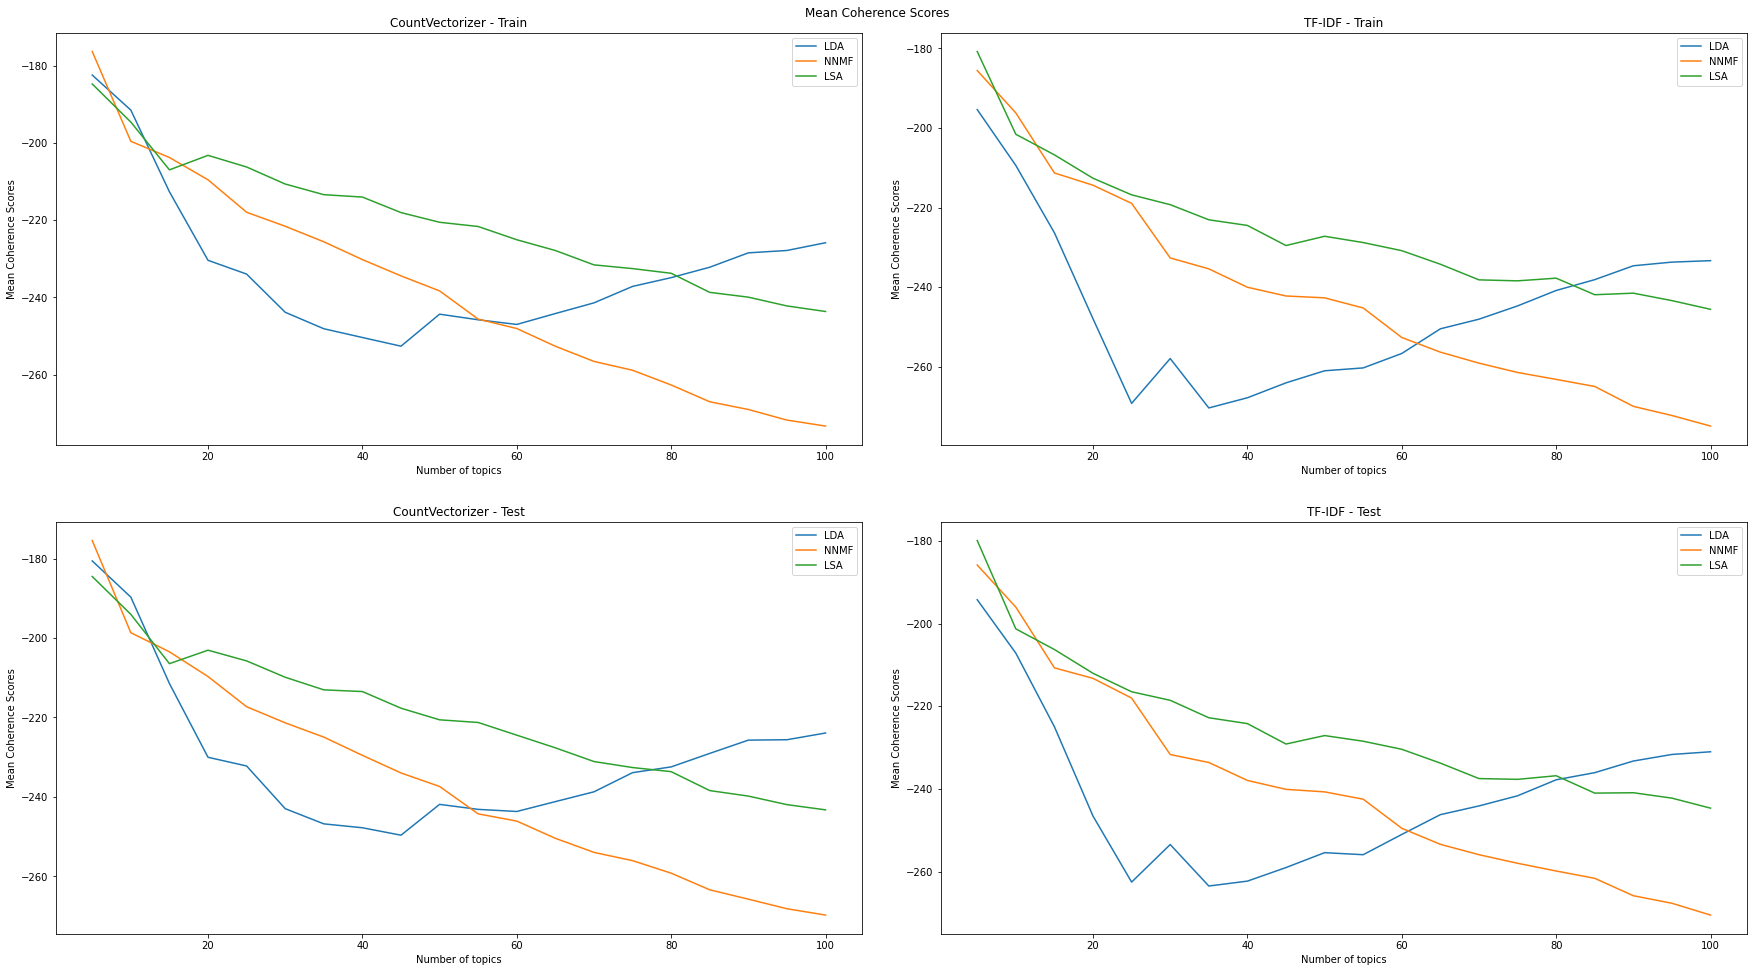

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

fig.set_figheight(14)
fig.set_figwidth(25)

fig.suptitle('Mean Coherence Scores')
axs[0,0].plot(Topics, Mean_Count_LDA_Coherence_train)
axs[0,0].plot(Topics, Mean_Count_NNMF_Coherence_train)
axs[0,0].plot(Topics, Mean_Count_LSA_Coherence_train)
axs[0,0].legend(['LDA', 'NNMF', 'LSA'])
axs[0,0].set(title='CountVectorizer - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[0,1].plot(Topics, Mean_TFIDF_LDA_Coherence_train)
axs[0,1].plot(Topics, Mean_TFIDF_NNMF_Coherence_train)
axs[0,1].plot(Topics, Mean_TFIDF_LSA_Coherence_train)
axs[0,1].legend(['LDA', 'NNMF', 'LSA'])
axs[0,1].set(title='TF-IDF - Train', xlabel='Number of topics', ylabel='Mean Coherence Scores')

axs[1,0].plot(Topics, Mean_Count_LDA_Coherence_test)
axs[1,0].plot(Topics, Mean_Count_NNMF_Coherence_test)
axs[1,0].plot(Topics, Mean_Count_LSA_Coherence_test)
axs[1,0].legend(['LDA', 'NNMF', 'LSA'])
axs[1,0].set(title='CountVectorizer - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')


axs[1,1].plot(Topics, Mean_TFIDF_LDA_Coherence_test)
axs[1,1].plot(Topics, Mean_TFIDF_NNMF_Coherence_test)
axs[1,1].plot(Topics, Mean_TFIDF_LSA_Coherence_test)
axs[1,1].legend(['LDA', 'NNMF', 'LSA'])
axs[1,1].set(title='TF-IDF - Test', xlabel='Number of topics', ylabel='Mean Coherence Scores')


fig.tight_layout(pad=3.0)
fig.show()

- La cohérence moyenne des topics est maximale en utilisant le LSA, sauf lorsqu'on utitlise un grand nombre de topics. 

- Avec un grand nombre de topics, mieux vaut utiliser le LDA.

###  3.3.2. Coeficient de Variation des Cohérences des Topics

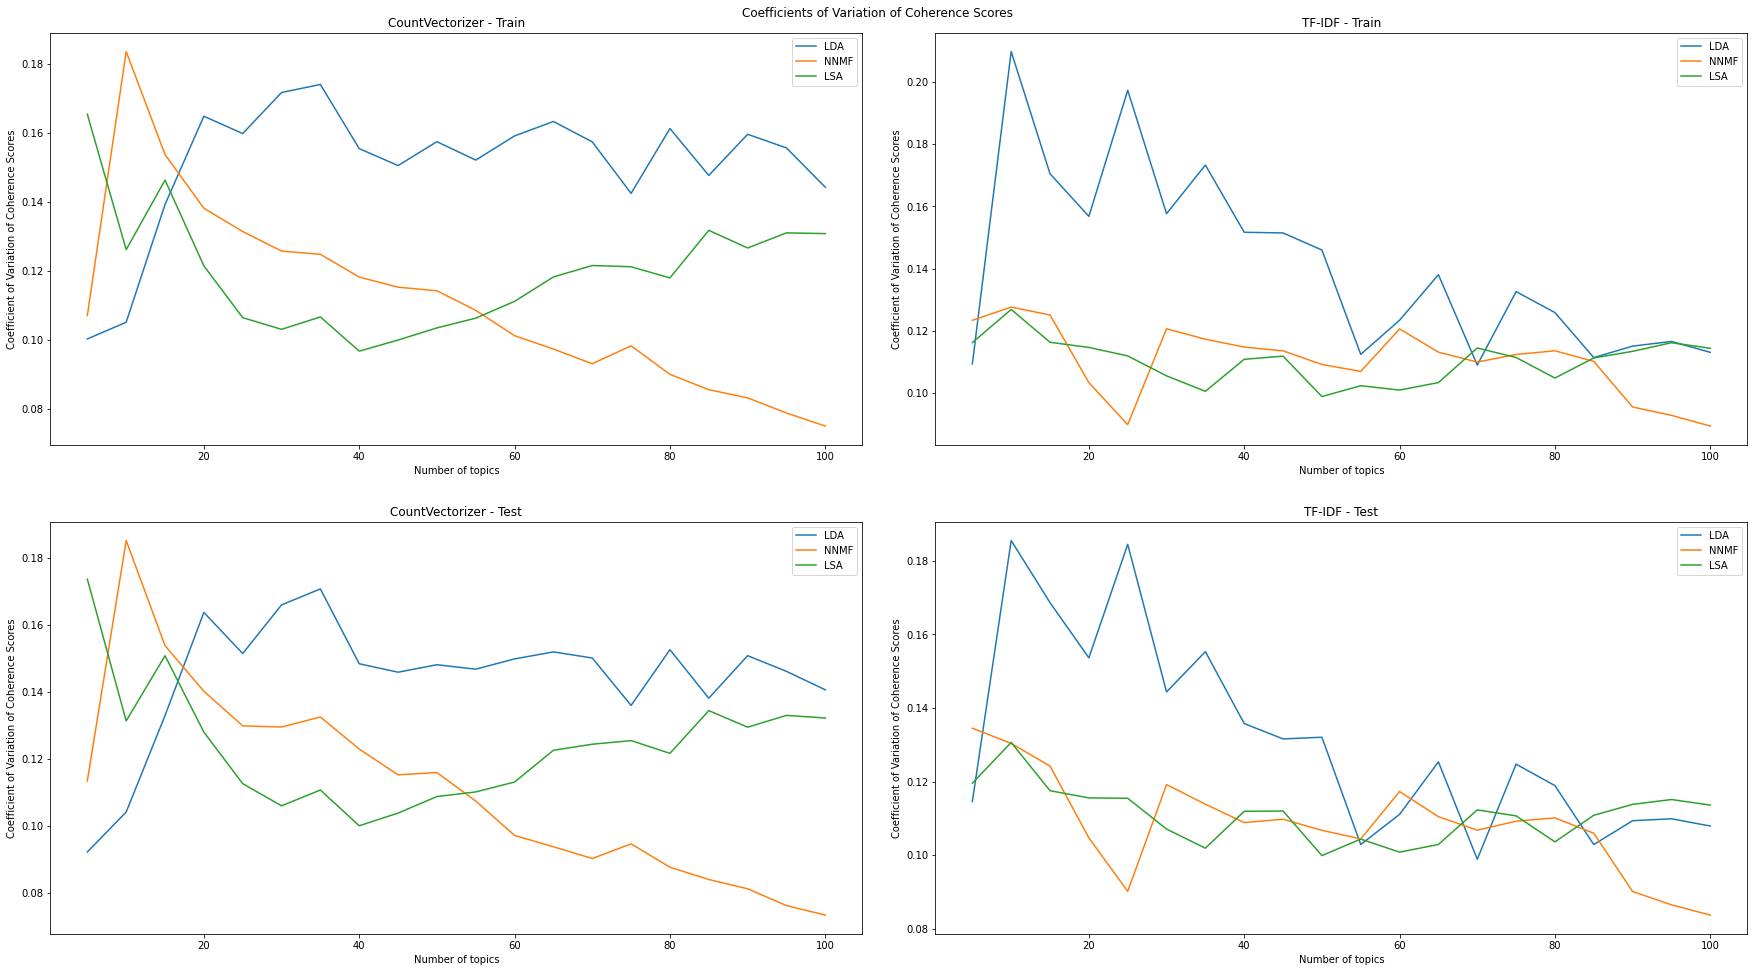

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2)

fig.set_figheight(14)
fig.set_figwidth(25)

fig.suptitle('Coefficients of Variation of Coherence Scores')
axs[0,0].plot(Topics, CV_Count_LDA_Coherence_train)
axs[0,0].plot(Topics, CV_Count_NNMF_Coherence_train)
axs[0,0].plot(Topics, CV_Count_LSA_Coherence_train)
axs[0,0].legend(['LDA', 'NNMF', 'LSA'])
axs[0,0].set(title='CountVectorizer - Train', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

axs[0,1].plot(Topics, CV_TFIDF_LDA_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_NNMF_Coherence_train)
axs[0,1].plot(Topics, CV_TFIDF_LSA_Coherence_train)
axs[0,1].legend(['LDA', 'NNMF', 'LSA'])
axs[0,1].set(title='TF-IDF - Train', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')

axs[1,0].plot(Topics, CV_Count_LDA_Coherence_test)
axs[1,0].plot(Topics, CV_Count_NNMF_Coherence_test)
axs[1,0].plot(Topics, CV_Count_LSA_Coherence_test)
axs[1,0].legend(['LDA', 'NNMF', 'LSA'])
axs[1,0].set(title='CountVectorizer - Test', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')


axs[1,1].plot(Topics, CV_TFIDF_LDA_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_NNMF_Coherence_test)
axs[1,1].plot(Topics, CV_TFIDF_LSA_Coherence_test)
axs[1,1].legend(['LDA', 'NNMF', 'LSA'])
axs[1,1].set(title='TF-IDF - Test', xlabel='Number of topics', ylabel='Coefficient of Variation of Coherence Scores')


fig.tight_layout(pad=3.0)
fig.show()

- Le coeficient de variation de la cohérence des topics est généralement plus évelé avec le LDA, qu'avec les autres méthodes. 

###  3.3.3. Temps de Calcul

In [ ]:
import pandas as pd

Methods = ['LDA', 'NNMF', 'LSA']
CountVectorizer_time = ['58 minutes', '42 minutes', '19 minutes']
TFIDF_time = ['39 minutes', '56 minutes', '20 minutes']
Index = ['CountVectorizer', 'TF_IDF']

List_Of_List = [CountVectorizer_time, TFIDF_time]

Time = pd.DataFrame(List_Of_List, columns = Methods, index=Index)

print(Time)

                        LDA        NNMF         LSA
CountVectorizer  58 minutes  42 minutes  19 minutes
TF_IDF           39 minutes  56 minutes  20 minutes


- La méthode du LSA est 2 à 3 fois plus rapide que les autres.
- Le CountVectorizer accélère les performances du LDA, mais ralentit celles du NNMF.
- Le TF-IDF accélère les performances du NNMF, mais ralentit celles du LDA.

# 4. BERT et Top2Vec

In [ ]:
Titles = []

for i in range(len(Data)):
  Titles.append(Data['Title'].iloc[i])

## 4.1. Top2Vec

In [ ]:
def Topic_Coherence_Top2Vec(topic_words, DataFrame):

  Topic_Words = []

  for j in range(len(topic_words)):
    Words = topic_words[j][:10]
    Topic_Words.append(Words)

  Topic_Coherence = []

  for i in range(len(topic_words)):
    Coherence = 0
    Count = 0
    for k in range(10):
      for h in range(10):
        if k != h :
          if (Topic_Words[i][k] in DataFrame.columns) & (Topic_Words[i][h] in DataFrame.columns):
            Count = Count + 1
            bla = (len(DataFrame[(DataFrame[Topic_Words[i][k]] > 0) & (DataFrame[Topic_Words[i][h]] > 0)]) + 1) / len(DataFrame[DataFrame[Topic_Words[i][k]] > 0])
            UMass = math.log(bla)
            Coherence = Coherence + UMass
    if Count != 0:
      Coherence = Coherence*90 / Count
      Topic_Coherence.append(Coherence)

  Average_Coherence = sum(Topic_Coherence) / len(Topic_Coherence)
  CoeficientVariation_Coherence = statistics.pstdev(Topic_Coherence) / abs(Average_Coherence)
  
  return Average_Coherence, CoeficientVariation_Coherence, Topic_Coherence

In [ ]:
pip install top2vec

     |████████████████████████████████| 15.3MB 390kB/s 
     |████████████████████████████████| 6.4MB 23.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 1.2MB 30.8MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311681 sha256=7d0ff96f0032ff88045016004a22abd0551d7bf3e07bbb2dd6f184dbe0b88e5f
  Stored in directory: /root/.cache/pip/wheels/42/63/fb/314ad6c3b270887a3ecb588b8e5aac50b0fad38ff89bb6dff2
Successfully built hdbscan
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=453b499f2e6af9b851588c8768e54325c3ef56acb9ca1be5f976b7e4e41a8084
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.2-cp37-none-any.whl size=513

In [ ]:
pip install top2vec[sentence_encoders]

     |████████████████████████████████| 4.3MB 11.4MB/s 


In [ ]:
pip install top2vec[sentence_transformers]

     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 2.5MB 13.5MB/s 
     |████████████████████████████████| 1.2MB 38.4MB/s 
     |████████████████████████████████| 901kB 38.2MB/s 
     |████████████████████████████████| 3.3MB 15.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.2.0-cp37-none-any.whl size=123339 sha256=ddd937dfd35b9a621c01695eb6bbd14e5d2b258ad4e4579fdf187e5e921e161e
  Stored in directory: /root/.cache/pip/wheels/0f/06/f7/faaa96fdda87462b4fd5c47b343340e9d5531ef70d0eef8242
Successfully built sentence-transformers


In [ ]:
pip install top2vec[indexing]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.5.1-cp37-cp37m-linux_x86_64.whl size=1296764 sha256=bf50b37ba904b31a4416d921c7d7733958de70a80f3d4b0b9812fa5adbac1e6e
  Stored in directory: /root/.cache/pip/wheels/46/7b/98/44c3a8a284506a54993f0b321e4a32a0c9e69215bbb72feff5
Successfully built hnswlib


### 4.1.1. Top2Vec appliqué sur Bag of Words

In [ ]:
from top2vec import Top2Vec

model = Top2Vec(Corpus, embedding_model='universal-sentence-encoder')

2021-06-22 09:13:04,528 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-06-22 09:13:10,512 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-06-22 09:13:14,183 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-06-22 09:13:25,514 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-06-22 09:14:26,729 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-06-22 09:14:32,170 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(len(topic_sizes))

In [ ]:
Average_Coherence, CoeficientVariation_Coherence, Coherence = Topic_Coherence_Top2Vec(topic_words, Count_Data)

print('Top2Vec sur Bags of Words')
print(' ')
print('Number of Topics : ', len(topic_sizes))
print('Coherence Moyenne : ', Average_Coherence)
print('Coeficient de Variation de la Coherence : ', CoeficientVariation_Coherence)

Top2Vec sur Bags of Words
 
Number of Topics :  279
Coherence Moyenne :  -367.0860542183924
Coeficient de Variation de la Coherence :  0.11252149596272223


### 4.1.2. Top2Vec appliqué sur Titres bruts

In [ ]:
from top2vec import Top2Vec

model = Top2Vec(Titles, embedding_model='universal-sentence-encoder')

2021-06-22 09:01:58,848 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-06-22 09:02:00,581 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2021-06-22 09:02:03,914 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-06-22 09:02:08,663 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-06-22 09:03:10,878 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-06-22 09:03:14,137 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
topic_sizes, topic_nums = model.get_topic_sizes()

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics(len(topic_sizes))

In [ ]:
Average_Coherence, CoeficientVariation_Coherence, Coherence = Topic_Coherence_Top2Vec(topic_words, Count_Data)

print('Top2Vec sur Titres bruts')
print(' ')
print('Number of Topics : ', len(topic_sizes))
print('Coherence Moyenne : ', Average_Coherence)
print('Coeficient de Variation de la Coherence : ', CoeficientVariation_Coherence)

Top2Vec sur Titres bruts
 
Number of Topics :  374
Coherence Moyenne :  -364.85820288009637
Coeficient de Variation de la Coherence :  0.19488026567458452


## 4.2. BERT

In [ ]:
!pip3 install bertopic[all]

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 13.2MB 9.0MB/s 
     |████████████████████████████████| 81kB 8.9MB/s 
     |████████████████████████████████| 6.4MB 22.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/3f/03/c3526fb4e79a793498829ca570f2f868204ad9a8040afcd72d82a8f121db/numpy-1.21.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
     |████████████████████████████████| 81kB 8.1MB/s 
     |████████████████████████████████| 12.8MB 36.2MB/s 
     |████████████████████████████████| 450kB 34.2MB/s 
     |████████████████████████████████| 4.3MB 27.2MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 1.3MB 32.4MB/s 
     |████████████████████████████████| 1.2MB 35.5MB/s 
     |████████████████████████████████| 1.2MB 30.2MB/s 
     |████████

In [ ]:
import math
import statistics

def Topic_Coherence_Bert(topic_words, DataFrame):

  Topic_Coherence = []

  for i in range(len(topic_words)):
    Coherence = 0
    Count = 0
    for k in range(10):
      for h in range(10):
        if k != h :
          if (Topic_Words[i][k] in DataFrame.columns) & (Topic_Words[i][h] in DataFrame.columns):
            Count = Count + 1
            bla = (len(DataFrame[(DataFrame[Topic_Words[i][k]] > 0) & (DataFrame[Topic_Words[i][h]] > 0)]) + 1) / len(DataFrame[DataFrame[Topic_Words[i][k]] > 0])
            UMass = math.log(bla)
            Coherence = Coherence + UMass
    if Count != 0:
      Coherence = Coherence*90 / Count
      Topic_Coherence.append(Coherence)

  Average_Coherence = sum(Topic_Coherence) / len(Topic_Coherence)
  CoeficientVariation_Coherence = statistics.pstdev(Topic_Coherence) / abs(Average_Coherence)
  
  return Average_Coherence, CoeficientVariation_Coherence, Topic_Coherence

In [ ]:
from bertopic import BERTopic

### 4.2.1. Top2Vec appliqué sur Bag of Words

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(Corpus)

In [ ]:
topic_freq = topic_model.get_topic_freq()

Topic_Words = []

for j in range(len(topic_freq['Topic']) - 1):
  Words = [] 
  for z in range(10):
    Words.append(topic_model.get_topic(j)[z][0])
  Topic_Words.append(Words)

In [ ]:
Average_Coherence, CoeficientVariation_Coherence, Topic_Coherence = Topic_Coherence_Bert(Topic_Words, Count_Data)

In [ ]:
print('BERT sur Bag of Words')
print(' ')
print('Nombre de Topics : ', max(topics))
print('Cohérence Moyenne : ', Average_Coherence)
print('Coéficient de Variation de la Cohérence ', CoeficientVariation_Coherence)

BERT sur Bag of Words
 
Nombre de Topics :  321
Cohérence Moyenne :  -341.20824145572016
Coéficient de Variation de la Cohérence  0.07965275630661531


### 4.2.2. BERT appliqué sur titres bruts

In [ ]:
topic_model = BERTopic(language="english", calculate_probabilities=True) # We need the probabilities to visualize
topics, _ = topic_model.fit_transform(Titles)

In [ ]:
topic_freq = topic_model.get_topic_freq()

Topic_Words = []

for j in range(len(topic_freq['Topic']) - 1):
  Words = [] 
  for z in range(10):
    Words.append(topic_model.get_topic(j)[z][0])
  Topic_Words.append(Words)

In [ ]:
Average_Coherence, CoeficientVariation_Coherence, Topic_Coherence = Topic_Coherence_Bert(Topic_Words, Count_Data)

In [ ]:
print('BERT sur Titres bruts')
print(' ')
print('Nombre de Topics : ', max(topics))
print('Cohérence Moyenne : ', Average_Coherence)
print('Coéficient de Variation de la Cohérence ', CoeficientVariation_Coherence)

BERT sur Titres bruts
 
Nombre de Topics :  594
Cohérence Moyenne :  -249.9614249333929
Coéficient de Variation de la Cohérence  0.2838728748560983


# 5. Conclusion

- Dans l'ensemble, aucune méthode ne domine les autres en tout point. 

- Nombre de topics:

  - Plus le nombre de topics est grand, plus leur cohérence diminue.

  - Le coéficient de variation de la cohérence des topics, n'est pas vraiment fonction du nombre de topics.

- LDA:
  - Temps de calcul assez long
  - Génère des topics plus cohérents que les autres méthodes, lorsque le nombre de topics est grand
  - Génère des topics inégalement cohérents (certains sont cohérents, d'autre le sont moins).
  - Plus rapide avec TF-IDF, mais génère des topics moins cohérents qu'avec Count-Vectorizer

- NNMF:
  - Temps de calcul assez long
  - Génère des topics toujours moins cohérents que LSA, et moins cohérents que LDA lorsque le nombre de topics est grand. 
  - La cohérence des topics est plus équitablement répartie qu'avec LDA, surtout lorsque le nombre de topics est grand.
  - TF-IDF ou CountVectorizer donnent des résultats comparables, mais CoutVectorizer est 30% plus rapide sur NNMF.


- LSA:
  - Temps de calcul bien plus rapide (2 à 3 fois moins de temps).
  - Génère des topics toujours plus cohérents que NNMF, et plus cohérents que LDA sauf lorsque le nombre de topics est grand. 
  - La cohérence des topics est aussi équitablement répartie qu'avec NNMF.
  - CountVectorizer donne des scores de cohérence généralement plus élevés qu'avec TF-IDF.

En somme:
  - le NNMF n'a pas beaucoup d'avantage comparé au LSA, et met 3 fois plus de temps de calcul (pour des performances légèrement moins bonnes).
  - Le LDA performe mieux que le LSA lorsque le nombre de topics est grand, mais met 3 fois plus de temps de calcul. 

Si l'on cherche à minimizer le temps de calcul, on choisira toujours LSA (avec TF-IDF ou CountVectorizer).

Si vraiment on cherche à identifier un grand nombre de topics différents, et que le temps de calcul est nullement un problème, on pourra éventuellement choisir LDA (soit avec TF-IDF pour réduire le temps de calcul de 30%, sinon avec Count-Vectorizer pour accroitre légèrement la cohérence des topics).

Enfin l'application des algorithmes de topic modelling plus récents a généré des résultats plus ambigus. Les deux algorithmes génèrent un nombre de très élevés de topics en reposant sur la méthode du HDBCAN, avec certains topics qui sont bien identifiés et d'autres qui le sont moins. Il semblerait que BERT fonctionne significativement mieux que Top2Vec sur des donénes brutes qui ne sont pas organisés en Bag of Words.